<a href="https://colab.research.google.com/github/rdepp123/devito/blob/master/BackPropMatt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError
from tensorflow.data import Dataset

Let's see if we can reproduce the following model from Matt Mazur blog and check all gradients and weights ...:
MODEL https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

Each output o1 and o2 is real between 0.0 and 1.0
*   Learning rate : 0.5
*   Loss : Mean Squarred Error
*   Optimizer : Simple Gradient Descent
*   Normalization : Sigmoid function
*   Bias : not updatable


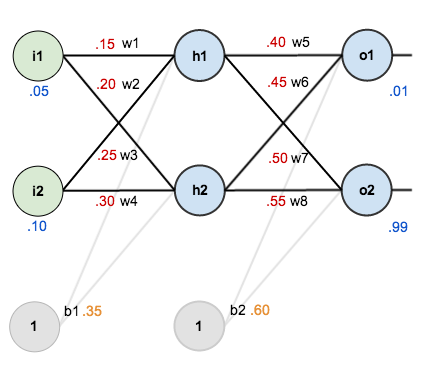

In [ ]:
#input_layer = Input(shape=(2,1))
inputs = tf.constant([[0.05, 0.1]])

In [ ]:
class SetBias(tf.keras.constraints.Constraint):
  """Constrains bias 1 to be 0.35"""

  def __init__(self, ref_value):
    self.ref_value = ref_value

  def __call__(self, bias):
    bias_cst=tf.fill(bias.shape, self.ref_value)
    return bias_cst

# Some useful functions

In [ ]:
def softmax(x):
  return np.exp(x)/np.sum(np.exp(x),axis=0)
def cross_entropy(y,y_pre):
  loss=-np.sum(y*np.log(y_pre))
  return loss/float(y_pre.shape[0])
def logistic(x):
  logistic=1/(1+np.exp(-x))
  return logistic

In [ ]:
def softmax(x):
  return np.exp(x)/np.sum(np.exp(x),axis=0)
def cross_entropy(y,y_pre):
  loss=-np.sum(y*np.log(y_pre))
  return loss/float(y_pre.shape[0])
def logistic(x):
  logistic=1/(1+np.exp(-x))
  return logistic

In [ ]:
x=np.array([0.1, 0.9, 4.0])
output=softmax(x)
print('Softmax in Python :',output)

In [ ]:
x=np.array([1.105905967, 1.224921404])
output=logistic(x)
print('logistics fn :',output)

In [ ]:
loss_fn=tf.keras.losses.MeanSquaredError()
y_pred = [[0.751365066, 0.772928476]]
y_true = [[0.01, 0.99]]

loss = loss_fn( y_true,y_pred)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.2983711>

#Create Layer1 and check if it fits Matt model

In [ ]:
# We set weights and biases according to Mattews example
setBias1=SetBias(0.35)
W1 = np.array([[0.15,0.25],[0.30,0.40]])
b1 = np.array([0.35,0.35])
dense_layer1 = layers.Dense(units=2,
                            use_bias=True,
                            bias_constraint=setBias1,
                            weights = [W1,b1],
                            activation=activations.sigmoid,
                            name='layer1'
                            )

Check that Layer 1 gives same result as Matt example

In [ ]:
h=dense_layer1(inputs)
# In his blog Mattews indicate out h1=0.593269992, out h2=0.596884378
out_h1=h[0][0]
out_h2=h[0][1]
#print('out h1= {0:.9f}'.format(h[0][0])+ '  out h2= {0:.9f}'.format(h[0][1]))
matt_h1=0.593269992
matt_h2=0.596884378
diff_h1 = out_h1-matt_h1
diff_h2 = out_h2-matt_h2
print('Model out h1= {0:.9f}'.format(out_h1)+ ' Model out h2= {0:.9f}'.format(out_h2))
print('Matt  out h1= {0:.9f}'.format(matt_h1)+ ' Matt  out h2= {0:.9f}'.format(matt_h2))
#print('diff h1= {0:.9f}'.format(diff_h1)+ '  diff h2= {0:.9f}'.format(diff_h2))


Model out h1= 0.595680773 Model out h2= 0.599288166
Matt  out h1= 0.593269992 Matt  out h2= 0.596884378


#Create layer 2 and check if it fits Matt model

1.   Élément de liste
2.   Élément de liste



In [ ]:
# We set weights and biases according to Matt example
setBias2=SetBias(0.6)

W2 = np.array([[0.4,0.5],[0.45,0.55]])
b2 = np.array([0.6,0.6])
dense_layer2 = layers.Dense(units=2,
                            use_bias=True,
                            bias_constraint=setBias2,
                            weights = [W2,b2],
                            activation=activations.sigmoid,
                            name='layer2'
                            )



Check that Layer 2 gives same results as Matt Example

---



---



In [ ]:
o=dense_layer2(h)
# In his blog Mattews indicate out o1=0.75136507, out o2=0.772928465
out_o1=o[0][0]
out_o2=o[0][1]
#print('out o1= {0:.9f}'.format(o[0][0])+ '  out o2= {0:.9f}'.format(o[0][1]))
matt_o1=0.75136507
matt_o2=0.772928465
diff_o1 = out_o1-matt_o1
diff_o2 = out_o2-matt_o2
print('Model out o1= {0:.9f}'.format(out_o1)+ ' Model out o2= {0:.9f}'.format(out_o2))
print('Matt  out o1= {0:.9f}'.format(matt_o1)+ ' Matt  out o2= {0:.9f}'.format(matt_o2))
#print('diff o1= {0:.9f}'.format(diff_o1)+ '  diff o2= {0:.9f}'.format(diff_o2))

Model out o1= 0.751747072 Model out o2= 0.773371816
Matt  out o1= 0.751365070 Matt  out o2= 0.772928465


# Create the Matt Model :
# Input => Layer1 => Layer 2

In [ ]:
#creation of the Matt model
layer_inputs = Input(shape=(2,))
out_layer1=dense_layer1(layer_inputs)
out_layer2=dense_layer2(out_layer1)
matt_model=Model(layer_inputs,out_layer2)
matt_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 layer1 (Dense)              (None, 2)                 6         
                                                                 
 layer2 (Dense)              (None, 2)                 6         
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#test Matt model
model_o=matt_model(inputs)
model_o1=model_o[0][0]
model_o2=model_o[0][1]

matt_o1=0.75136507
matt_o2=0.772928465
model_diff_o1 = model_o1-matt_o1
model_diff_o2 = model_o2-matt_o2
print('Model out o1= {0:.9f}'.format(model_o1)+ ' Model out o2= {0:.9f}'.format(model_o2))
print('Matt  out o1= {0:.9f}'.format(matt_o1)+ ' Matt  out o2= {0:.9f}'.format(matt_o2))

Model out o1= 0.751747072 Model out o2= 0.773371816
Matt  out o1= 0.751365070 Matt  out o2= 0.772928465


# Compile Matt Model with loss=MeanSquarredError


*   fit model on 1 input to see
    gradients w1 to w4 on layer1 after 1 backpropagation
*   fit model on a second input ( the same input) to see
    gradients w5 to w8 on layer2 after 2 backpropagation


In [ ]:

# matt inputs
inputs = tf.constant([[0.05, 0.1]])
batch_input=np.vstack([inputs]*2)

W1 = np.array([[0.15,0.25],[0.2,0.3]]) # we initialize the weights according to Mattews example
b1 = np.array([0.35,0.35])             # we initialize biases according to Mattews example
setBias1=SetBias(0.35)
#

W2 = np.array([[0.4,0.5],[0.45,0.55]])
b2 = np.array([0.6,0.6])
setBias2=SetBias(0.6)

In [ ]:

setBias1=SetBias(0.35)
dense_layer1 = layers.Dense(units=2,
                            use_bias=True,
                            bias_constraint=setBias1,
                            weights = [W1,b1],
                            activation=activations.sigmoid,
                            name='layer1'
                            )
setBias1=SetBias(0.60)
dense_layer2 = layers.Dense(units=2,
                            use_bias=True,
                            bias_constraint=setBias2,
                            weights = [W2,b2],
                            activation=activations.sigmoid,
                            name='layer2'
                            )

#creation of the Mattews model

layer_inputs = Input(shape=(2,))
out_layer1=dense_layer1(layer_inputs)
out_layer2=dense_layer2(out_layer1)
matt_model=Model(layer_inputs,out_layer2)
matt_model.summary()

#test model
model_o=matt_model(inputs)
model_o1=model_o[0][0]
model_o2=model_o[0][1]

matt_o1=0.75136507
matt_o2=0.772928465
model_diff_o1 = model_o1-matt_o1
model_diff_o2 = model_o2-matt_o2
print('Model out o1= {0:.9f}'.format(model_o1)+ ' Model out o2= {0:.9f}'.format(model_o2))
print('Matt  out o1= {0:.9f}'.format(matt_o1)+ ' Matt  out o2= {0:.9f}'.format(matt_o2))

# Compile model
matt_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizers.legacy.SGD(learning_rate=0.5), metrics=['accuracy'])

#training dataset
x_tr=np.vstack([inputs]*1)
y_true=np.array([0.01,0.99])
y_tr=np.vstack([y_true]*1)

#Let's train on only one backpropagation
#matt_model.fit(x_tr, y_tr, epochs=1, batch_size=1, verbose=1, validation_split=0.0)
#matt_model.summary

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 layer1 (Dense)              (None, 2)                 6         
                                                                 
 layer2 (Dense)              (None, 2)                 6         
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model out o1= 0.751365066 Model out o2= 0.772928476
Matt  out o1= 0.751365070 Matt  out o2= 0.772928465


In [ ]:
#after 1 training (1 back propagation) Weights at step 1:
matt_model.fit(x_tr, y_tr, epochs=1, batch_size=1, verbose=1, validation_split=0.0)
matt_model.weights

1/1 [==============================] - 0s 427ms/step - loss: 0.2984 - accuracy: 1.0000


[<tf.Variable 'layer1/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[0.14978072, 0.24975115],
        [0.19956143, 0.2995023 ]], dtype=float32)>,
 <tf.Variable 'layer1/bias:0' shape=(2,) dtype=float32, numpy=array([0.35, 0.35], dtype=float32)>,
 <tf.Variable 'layer2/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[0.3589165 , 0.5113013 ],
        [0.40866616, 0.56137013]], dtype=float32)>,
 <tf.Variable 'layer2/bias:0' shape=(2,) dtype=float32, numpy=array([0.6, 0.6], dtype=float32)>]

Run a second backward propagation

In [ ]:
#after 2 training of 1 epoch of batch=1 (2 back propagations) Weights at step 2:
matt_model.fit(x_tr, y_tr, epochs=1, batch_size=1, verbose=1, validation_split=0.0)
matt_model.trainable_weights

1/1 [==============================] - 0s 8ms/step - loss: 0.2910 - accuracy: 1.0000


[<tf.Variable 'layer1/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[0.14959273, 0.24953303],
        [0.19918543, 0.29906607]], dtype=float32)>,
 <tf.Variable 'layer1/bias:0' shape=(2,) dtype=float32, numpy=array([0.35, 0.35], dtype=float32)>,
 <tf.Variable 'layer2/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[0.31735387, 0.52239734],
        [0.36685044, 0.5725338 ]], dtype=float32)>,
 <tf.Variable 'layer2/bias:0' shape=(2,) dtype=float32, numpy=array([0.6, 0.6], dtype=float32)>]

# Train the model on 1000 epoch
  The output should be close to [0.01, 0.99]



In [ ]:
#training dataset
x_tr=np.vstack([inputs]*10)
y_true=np.array([0.01,0.99])
y_tr=np.vstack([y_true]*10)

#Let's train on only one backpropagation
history=matt_model.fit(x_tr, y_tr, epochs=1000, batch_size=1, verbose=1, validation_split=0.0)
#matt_model.summary

Epoch 1/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2485 - accuracy: 1.0000
Epoch 2/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1730 - accuracy: 1.0000
Epoch 3/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1149 - accuracy: 1.0000
Epoch 4/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0784 - accuracy: 1.0000
Epoch 5/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0567 - accuracy: 1.0000
Epoch 6/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0434 - accuracy: 1.0000
Epoch 7/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0347 - accuracy: 1.0000
Epoch 8/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 1.0000
Epoch 9/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 1.0000
Epoch 10/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 1.0000

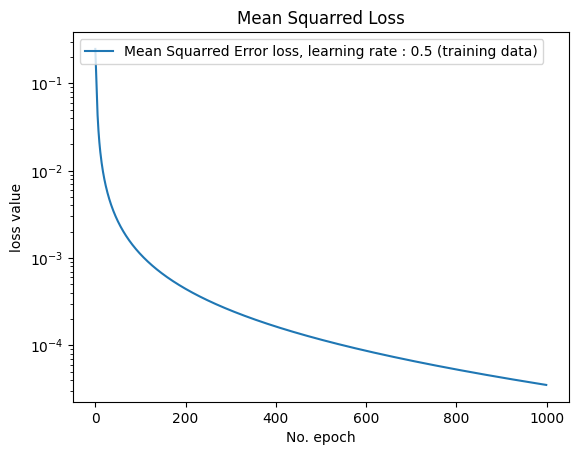

In [ ]:
# Visualize training process
plt.plot(history.history['loss'], label='Mean Squarred Error loss, learning rate : 0.5 (training data)')
#plt.plot(history.history['accuracy'], label='accuracy (training data)')
plt.title('Mean Squarred Loss')
plt.ylabel('loss value')
plt.yscale('log')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
matt_model.trainable_weights

[<tf.Variable 'layer1/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[0.37851793, 0.47730803],
        [0.65703505, 0.7546152 ]], dtype=float32)>,
 <tf.Variable 'layer1/bias:0' shape=(2,) dtype=float32, numpy=array([0.35, 0.35], dtype=float32)>,
 <tf.Variable 'layer2/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-3.8930314,  2.86187  ],
        [-3.868474 ,  2.9257443]], dtype=float32)>,
 <tf.Variable 'layer2/bias:0' shape=(2,) dtype=float32, numpy=array([0.6, 0.6], dtype=float32)>]

In [ ]:
# let see the results
matt_model(inputs)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.01591251, 0.9840654 ]], dtype=float32)>

# Matt Model : See the gradients
 We create a Custom training loop to see/update the gradients during training using GradientTape()





In [ ]:
# mattews inputs
#inputs = tf.constant([[0.05, 0.1]])
#batch_input=np.vstack([inputs]*2)

#W1 = np.array([[0.15,0.25],[0.2,0.3]]) # we initialize the weights according to Mattews example
#b1 = np.array([0.35,0.35])             # we initialize biases according to Mattews example
#setBias1=SetBias(0.35)
#

#W2 = np.array([[0.4,0.5],[0.45,0.55]])
#b2 = np.array([0.6,0.6])
#setBias2=SetBias(0.6)

#Let's reset the layers
dense_layer1 = layers.Dense(units=2,
                            use_bias=True,
                            bias_constraint=setBias1,
                            weights = [W1,b1],
                            activation=activations.sigmoid,
                            name='layer1'
                            )

dense_layer2 = layers.Dense(units=2,
                            use_bias=True,
                            bias_constraint=setBias2,
                            weights = [W2,b2],
                            activation=activations.sigmoid,
                            name='layer2'
                            )
layer_inputs = Input(shape=(2,))
out_layer1=dense_layer1(layer_inputs)
out_layer2=dense_layer2(out_layer1)
matt_model=Model(layer_inputs,out_layer2)
matt_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizers.legacy.SGD(learning_rate=0.5), metrics=['accuracy'])


In [ ]:
#x_tr = tf.constant([[0.05, 0.1],[0.05, 0.1]])
#y_tr = tf.constant([[0.01, 0.99],[0.01, 0.99]])
x_tr = tf.constant([[0.05, 0.1]])
y_tr = tf.constant([[0.01, 0.99]])

xdataset = tf.data.Dataset.from_tensor_slices([x_tr])
ydataset = tf.data.Dataset.from_tensor_slices([y_tr])
tr_dataset = tf.data.Dataset.zip(xdataset, ydataset)


loss_fn=tf.keras.losses.MeanSquaredError()
optimizer_leg = tf.keras.optimizers.legacy.SGD(learning_rate=0.5)

for (x, y_true) in tr_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        y_pred = matt_model(x)
        # Loss value for this batch of 1 input
        loss = loss_fn( y_true,y_pred)

    # Get gradients of the loss wrt the weights.
    gradients = tape.gradient(loss, matt_model.trainable_weights)
    trainable_weights=matt_model.trainable_weights
    #Update the weights of our linear layer.
    optimizer_leg.apply_gradients(zip(gradients, matt_model.trainable_weights))

    # Logging.
    print( f'gradients {gradients}, \n      Loss : {float(loss)}')
    # Loss should be about 0.29837111 after 1 backpropagation
    # Loss should be about 0.29102792 after 2 backpropagation


gradients [<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.00043857, 0.00049771],
       [0.00087714, 0.00099543]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.00877136, 0.00995425], dtype=float32)>, <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.08216704, -0.02260254],
       [ 0.08266763, -0.02274024]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.13849856, -0.03809823], dtype=float32)>], 
      Loss : 0.2983711063861847


In [ ]:
matt_model.trainable_weights

[<tf.Variable 'layer1/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[0.14978072, 0.24975115],
        [0.19956143, 0.2995023 ]], dtype=float32)>,
 <tf.Variable 'layer1/bias:0' shape=(2,) dtype=float32, numpy=array([0.6, 0.6], dtype=float32)>,
 <tf.Variable 'layer2/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[0.3589165 , 0.5113013 ],
        [0.40866616, 0.56137013]], dtype=float32)>,
 <tf.Variable 'layer2/bias:0' shape=(2,) dtype=float32, numpy=array([0.6, 0.6], dtype=float32)>]